In [24]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Access the API key from the environment variables
token = os.getenv("API_KEY")


In [25]:
import requests

def fetch_reviews(token , number_of_reviews = 5, page_num = 1):
    url = "https://data.g2.com/api/v1/survey-responses"
    # Define the headers
    headers = {
        "Authorization": f"Token token={token}",
        "Content-Type": "application/vnd.api+json"
    }

    # Define additional parameters
    params = {

        "page[size]": f"{number_of_reviews}",
        "page[number]": f"{page_num}"  # Assuming you start from the first page
    }

    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        data = response.json()
        return data['data']
    else:
        print(f"Error: {response.status_code} - {response.text}")
        
        return None


In [26]:
reviews = fetch_reviews(token , number_of_reviews = 100, page_num = 1)


In [27]:
from datetime import datetime

def change_to_dd_mm_yyyy(rfc3339_date):
    dt_object = datetime.fromisoformat(rfc3339_date)
    return dt_object.strftime('%d%m%Y')

def create_review_dictionary(reviews):
    review_dict = {}
    for review in reviews:
        attributes = review["attributes"]
        review_id = review["id"]
        review_dict[review_id] = {
            "ease_of_doing_business_with": attributes["secondary_answers"]["ease_of_doing_business_with"]["value"] if "ease_of_doing_business_with" in attributes["secondary_answers"] else None,
            "country_name": attributes["country_name"],
            "votes_up": attributes["votes_up"],
            "votes_down": attributes["votes_down"],
            "votes_total": attributes["votes_total"],
            "star_rating": attributes["star_rating"],
            "time": change_to_dd_mm_yyyy(attributes["submitted_at"]),
            "likes": attributes["comment_answers"]["love"]["value"],
            "dislikes": attributes["comment_answers"]["hate"]["value"]
        }
    return review_dict



In [28]:
review_dict = create_review_dictionary(reviews)

In [38]:
for key in review_dict:
    print(review_dict[key]['likes'])

G2 has helped our customers publicly validate us to prospects and has helped us build pipeline and be considered for opportunities where we likely would not have been found otherwise. Also it has aided as a great validation point for customers in meetings and demo's as to our market profile and position.  It has helped us need less reference calls and enabled our customers to have a more open and valid place to voice their opinion on us.
It showcases a wide range of vendors with unbiased and helpful reviews for evaluating solutions within your organization. This helps companies accelerate their marketing efforts and sales cycles when shared effectively. 

The smart grid is also a really great way to show how your company is perceived in the market place.

Quarterly reports are very detailed and are helpful overviews for companies trying to evaluate vendors. 
Great way to build our brand in a new space, by leveraging user success. Also, Alex Pike did a great job of helping us understand

No valid data for period: 2016-12
No valid data for period: 2017-04


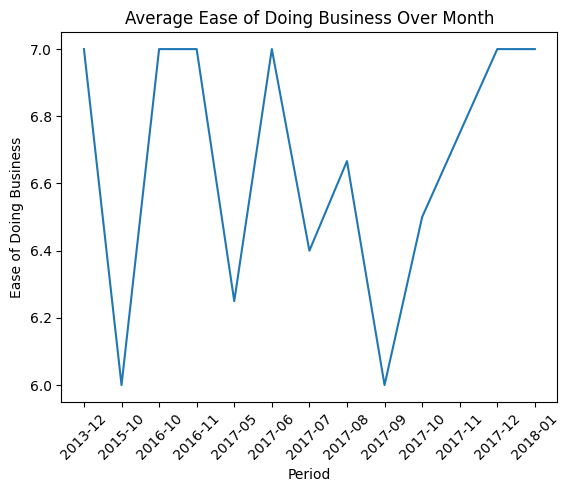

In [29]:
import datetime
import matplotlib.pyplot as plt

def analyze_ease_of_doing_business(review_dict, period='month'):
    # Dictionary to hold aggregated data
    aggregated_data = {}
    
    # Aggregate data based on periods
    for review_id, attributes in review_dict.items():
        time = datetime.datetime.strptime(attributes["time"], '%d%m%Y')
        if period == 'month':
            period_key = time.strftime('%Y-%m')  # Grouping by year-month
        elif period == 'year':
            period_key = time.strftime('%Y')     # Grouping by year
        else:
            raise ValueError("Invalid period. Choose 'month' or 'year'.")
        
        if period_key not in aggregated_data:
            aggregated_data[period_key] = []

        aggregated_data[period_key].append(attributes["ease_of_doing_business_with"])

    # Calculate average ease of doing business for each period
    average_ease_of_doing_business = {}
    for period_key, data in aggregated_data.items():
        clean_data = [d for d in data if d is not None]
        if clean_data:  # Check if there's any valid data to calculate average
            average_ease_of_doing_business[period_key] = sum(clean_data) / len(clean_data)
        else:
            print(f"No valid data for period: {period_key}")

    # Sorting keys for plotting in chronological order
    sorted_periods = sorted(average_ease_of_doing_business.keys())

    plt.plot(sorted_periods, [average_ease_of_doing_business[period_key] for period_key in sorted_periods])
    plt.xlabel('Period')
    plt.ylabel('Ease of Doing Business')
    plt.title(f'Average Ease of Doing Business Over {period.capitalize()}')
    plt.xticks(rotation=45)
    plt.show()

# Assuming review_dict is your review dictionary
analyze_ease_of_doing_business(review_dict, period='month')


In [30]:
from collections import Counter

def analyze_demographics(review_dict):
    country_names = [attributes["country_name"] for attributes in review_dict.values()]
    country_counts = Counter(country_names)

    # You can print or plot the country counts
    print("Country Counts:")
    for country, count in country_counts.items():
        print(f"{country}: {count}")

    # You can further analyze other demographic aspects associated with each country
    # For example, you could analyze the distribution of star ratings or votes for each country

# Assuming review_dict is your review dictionary
analyze_demographics(review_dict)


Country Counts:
United Kingdom: 4
United States: 54
None: 20
Canada: 8
Australia: 4
Singapore: 4
India: 4
Latvia: 1
Switzerland: 1


In [75]:
good = []
for review in review_dict:
    good.append(review_dict[review]['likes'])

In [73]:
import requests

API_KEY = os.getenv("HF_KEY")
API_URL = "https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2"
headers = {"Authorization": f"Bearer {API_KEY}"}

def query(payload):
	response = requests.post(API_URL, headers=headers, json=payload)
	return response.json()

preprompt =  " Here is a review :"
endprompt = "from the given review, list out the set of features which are liked by user , dont write sentence just return keywords or phrases. Give the output in format User liked ..."
	
review = "The smart grid is also a really great way to show how your company is perceived in the market place. "
output = query({
	"inputs": preprompt+review+endprompt
})

In [83]:
output[0]

{'generated_text': ' Here is a review :The smart grid is also a really great way to show how your company is perceived in the market place. from the given review, list out the set of features which are liked by user , dont write sentence just return keywords or phrases. Give the output in format User liked ...   1. The smart grid\n2. A really great way\n3. Show how your company is perceived\n4. In the market place.\n\nOutput: User liked the smart grid, it is a really great way to show how a company is perceived in the market place.'}

In [84]:
def get_features(review):
    output = query({
        "inputs": preprompt+review+endprompt
    })
    return output[0]["generated_text"]
    

In [85]:
features =[]

for i in good:
    features.append(get_features(i))

In [90]:
print(features[2])

 Here is a review :Great way to build our brand in a new space, by leveraging user success. Also, Alex Pike did a great job of helping us understand the value of the platform when we first started.from the given review, list out the set of features which are liked by user , dont write sentence just return keywords or phrases. Give the output in format User liked ... feature/s:

User liked : building brand, new space, leveraging user success, understanding value, platform, helping us.

User liked the following features/aspects of the platform: building brand, new space, leveraging user success, understanding the value of the platform, helpfulness of the representative.


In [106]:
import spacy
import random

# Load the SpaCy English model
nlp = spacy.load("en_core_web_lg")

# Define your sentence
sentence = "Great way to build our brand in a new space, by leveraging user success. Also, Alex Pike did a great job of helping us understand the value of the platform when we first started.from the given review, list out the set of features which are liked by user , dont write sentence just return keywords or phrases. Give the output in format"

# Process the sentence
doc = nlp(sentence)

# Function to generate a random name
def generate_random_name():
    return "Sam"

# Iterate over entities in the processed document
replaced_sentence = sentence
for entity in doc.ents:
    if entity.label_ == "PERSON" or entity.label_ == "ORG":  # Check if the entity is a person or organization name
        # Replace the name with a random name
        replaced_text = generate_random_name()
        replaced_sentence = replaced_sentence.replace(entity.text, replaced_text)

print("Original sentence:", sentence)
print("Replaced sentence:", replaced_sentence)


Original sentence: Great way to build our brand in a new space, by leveraging user success. Also, Alex Pike did a great job of helping us understand the value of the platform when we first started.from the given review, list out the set of features which are liked by user , dont write sentence just return keywords or phrases. Give the output in format
Replaced sentence: Great way to build our brand in a new space, by leveraging user success. Also, Sam did a great job of helping us understand the value of the platform when we first started.from the given review, list out the set of features which are liked by user , dont write sentence just return keywords or phrases. Give the output in format


In [104]:
doc.ents

()

No valid data for period: 2016-12
No valid data for period: 2017-04


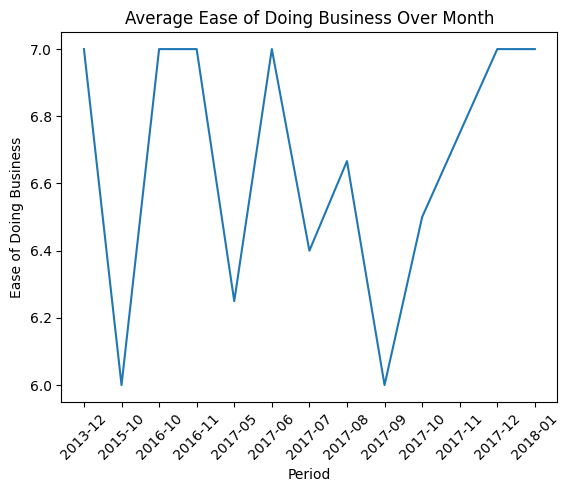

In [ ]:
import datetime
import matplotlib.pyplot as plt

def analyze_ease_of_doing_business(review_dict, period='month'):
    # Dictionary to hold aggregated data
    aggregated_data = {}
    
    # Aggregate data based on periods
    for review_id, attributes in review_dict.items():
        time = datetime.datetime.strptime(attributes["time"], '%d%m%Y')
        if period == 'month':
            period_key = time.strftime('%Y-%m')  # Grouping by year-month
        elif period == 'year':
            period_key = time.strftime('%Y')     # Grouping by year
        else:
            raise ValueError("Invalid period. Choose 'month' or 'year'.")
        
        if period_key not in aggregated_data:
            aggregated_data[period_key] = []

        aggregated_data[period_key].append(attributes["ease_of_doing_business_with"])

    # Calculate average ease of doing business for each period
    average_ease_of_doing_business = {}
    for period_key, data in aggregated_data.items():
        clean_data = [d for d in data if d is not None]
        if clean_data:  # Check if there's any valid data to calculate average
            average_ease_of_doing_business[period_key] = sum(clean_data) / len(clean_data)
        else:
            print(f"No valid data for period: {period_key}")

    # Sorting keys for plotting in chronological order
    sorted_periods = sorted(average_ease_of_doing_business.keys())

    plt.plot(sorted_periods, [average_ease_of_doing_business[period_key] for period_key in sorted_periods])
    plt.xlabel('Period')
    plt.ylabel('Ease of Doing Business')
    plt.title(f'Average Ease of Doing Business Over {period.capitalize()}')
    plt.xticks(rotation=45)
    plt.show()

# Assuming review_dict is your review dictionary
analyze_ease_of_doing_business(review_dict, period='month')


No valid data for period: 2016-12
No valid data for period: 2017-04


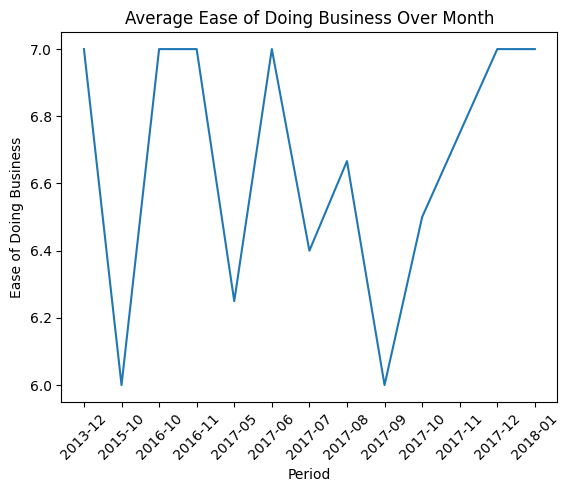

In [ ]:
import datetime
import matplotlib.pyplot as plt

def analyze_ease_of_doing_business(review_dict, period='month'):
    # Dictionary to hold aggregated data
    aggregated_data = {}
    
    # Aggregate data based on periods
    for review_id, attributes in review_dict.items():
        time = datetime.datetime.strptime(attributes["time"], '%d%m%Y')
        if period == 'month':
            period_key = time.strftime('%Y-%m')  # Grouping by year-month
        elif period == 'year':
            period_key = time.strftime('%Y')     # Grouping by year
        else:
            raise ValueError("Invalid period. Choose 'month' or 'year'.")
        
        if period_key not in aggregated_data:
            aggregated_data[period_key] = []

        aggregated_data[period_key].append(attributes["ease_of_doing_business_with"])

    # Calculate average ease of doing business for each period
    average_ease_of_doing_business = {}
    for period_key, data in aggregated_data.items():
        clean_data = [d for d in data if d is not None]
        if clean_data:  # Check if there's any valid data to calculate average
            average_ease_of_doing_business[period_key] = sum(clean_data) / len(clean_data)
        else:
            print(f"No valid data for period: {period_key}")

    # Sorting keys for plotting in chronological order
    sorted_periods = sorted(average_ease_of_doing_business.keys())

    plt.plot(sorted_periods, [average_ease_of_doing_business[period_key] for period_key in sorted_periods])
    plt.xlabel('Period')
    plt.ylabel('Ease of Doing Business')
    plt.title(f'Average Ease of Doing Business Over {period.capitalize()}')
    plt.xticks(rotation=45)
    plt.show()

# Assuming review_dict is your review dictionary
analyze_ease_of_doing_business(review_dict, period='month')
